In [1]:
import os
from scapy.all import *
import time
import pandas as pd
import ipaddress
import numpy as np

from trustee import RegressionTrustee
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', None) 

ModuleNotFoundError: No module named 'scapy'

# Trustee Data Analysis








In [117]:
df_vimeo = pd.read_csv("/mnt/md0/cs190n-test/vimeo_video_capture_ISCX.csv")

In [118]:
features = [
    "Flow Bytes/s", "Flow Packets/s", "Total Fwd Packet", "Total Bwd packets",
    "Total Length of Fwd Packet", "Total Length of Bwd Packet",
    "Packet Length Mean", "Flow IAT Mean", "Active Mean", "Idle Mean",
    "Protocol", "Down/Up Ratio", "Previous Download Time", "Previous Flow Bytes/s"
]

In [119]:
# create label column
df_vimeo['Label'] = 'other'

# if a flow has 30+ forward OR backward packets label it 'vimeo'
df_vimeo.loc[(df_vimeo['Total Fwd Packet'] > 30) | (df_vimeo['Total Bwd packets'] > 30), 'Label'] = 'vimeo'

# filter to only accept flows with label 'vimeo'
df_vimeo = df_vimeo[df_vimeo["Label"] == "vimeo"]

# create 'Download Time' column from flow duration (unit is seconds)
df_vimeo['Download Time'] = df_vimeo['Flow Duration'] / 1e6

# drop any flows that don't have a 'Download Time' value
df_vimeo = df_vimeo.dropna(subset=['Download Time'])

# Create lagged features for previous download times (e.g., lag1, lag2, etc.)
df_vimeo['Previous Download Time'] = df_vimeo['Download Time'].shift(1)
df_vimeo['Previous Flow Bytes/s'] = df_vimeo['Flow Bytes/s'].shift(1)

# Drop rows with NaN values from lagged features
df_vimeo.dropna(subset=['Previous Download Time'], inplace=True)

# fill in any <NA> fields with 0
df_vimeo.fillna(0, inplace=True)


In [2]:
# print(df_vimeo[['Timestamp', 'Previous Download Time', 'Download Time']])

In [126]:
# Define features and target variable
target_variable = 'Download Time'
train_features = [col for col in df_vimeo[features] if col != target_variable]

x_train = df_vimeo[train_features]
y_train = df_vimeo[target_variable]

# Initialize the RandomForestRegressor with some regularization
clf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=4, max_features='sqrt', random_state=15)

# Train the model
clf.fit(x_train, y_train)

# Predict on the training set
y_pred = clf.predict(x_train)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_train, y_pred))
print("R-squared:", r2_score(y_train, y_pred))

# Optionally, perform cross-validation to check the consistency of your model
scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation MSE:", -scores.mean())

Mean Squared Error: 21.859957763730065
R-squared: 0.9871877087275581
Cross-validation MSE: 80.26036490313228


Training score of pruned DT: 0.9999997304437709
Model explanation score report:
Mean Squared Error (on pruned tree predictions): 58.31549835396034
R-squared (on pruned tree predictions): 0.9658208328358154


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


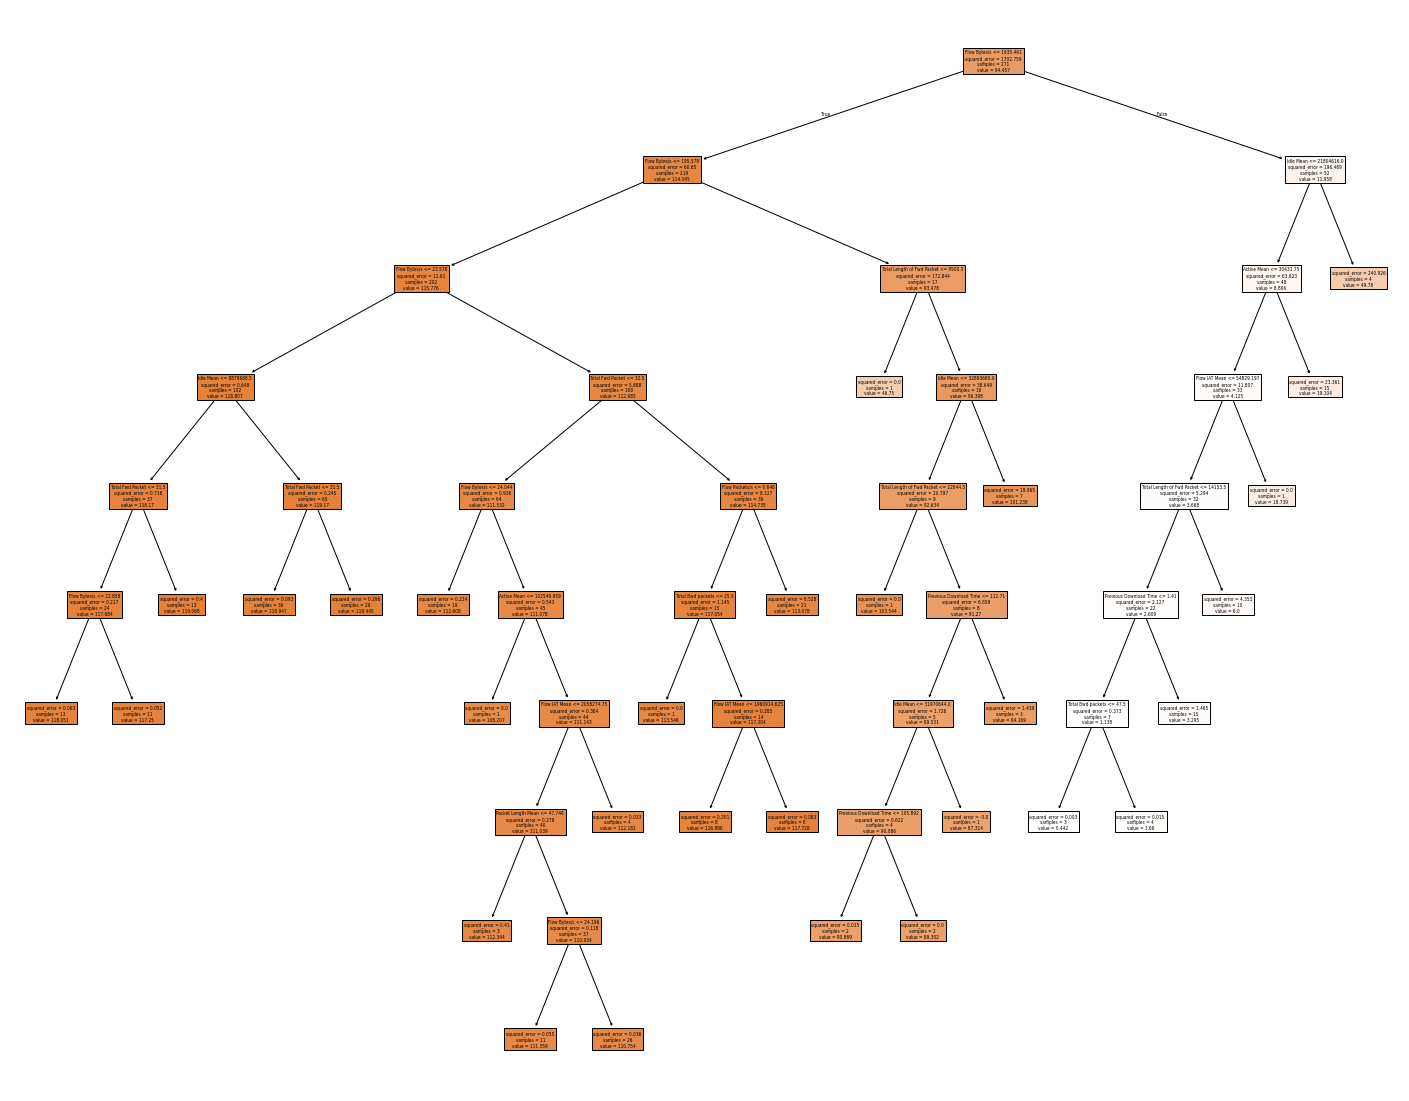

In [127]:
# Create and Train a Trustee Tree
trustee = RegressionTrustee(expert=clf)  # Use RegressionTrustee instead of ClassificationTrustee
trustee.fit(x_train, y_train, num_samples=len(x_train) // 2, num_iter=20, train_size=0.99)

# Display Trustee Results
_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")

# Predict using the pruned decision tree (from the trustee)
dt_y_pred = dt.predict(x_train)

# Model explanation score report
print("Model explanation score report:")
print(f"Mean Squared Error (on pruned tree predictions): {mean_squared_error(y_train, dt_y_pred)}")
print(f"R-squared (on pruned tree predictions): {r2_score(y_train, dt_y_pred)}")

# Visualize a tree from the Random Forest
fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=x_train.columns, class_names=sorted(df_vimeo['Download Time'].unique()), filled=True, max_depth=10)
plt.show()